## Profiling Tensorflow

This blog post is meant to surve as a basic tutorial for how to profile tensorflow.  I'll use several different networks for a basic classification task, and compare CPU vs. GPU performance with profiling tools.

By the way, this tutorial has networks trained by using singularity to pull in all the products I need.  There was just recently another blog post about singularity, check it out!

In [1]:
import os
import time

import numpy

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import timeline

### Classification Task

To keep things simple on the machine learning task side, I'll use the mnist data set as the input.  Tensorflow can provide the infrastructure for this.  New to me is the "Fashion MNIST" data set, which is kinda cool, so let's use that as something different than digits:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

This dataset comes down as just numpy ndarrays, like so:

In [4]:
print "x_train shape: " + str(x_train.shape)
print "y_train shape: " + str(y_train.shape)
print "x_test shape: " + str(x_test.shape)
print "y_test shape: " + str(y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


The dataset also comes randomized as well, which is nice:

In [5]:
print y_train[0:25]

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4]


We should also take a look at some of the images to see what we're getting in to:

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
# Get 40 images:
images = x_train[0:40]
# Reshape into 10x4 28x28 images, but as a 2D array for visualization:
visual_array = numpy.zeros([10*28, 4*28])
for col in range(10):
    for row in range(4):
        index = col + row*10
        visual_array[col*28:(col+1)*28, row*28:(row+1)*28] = images[index]

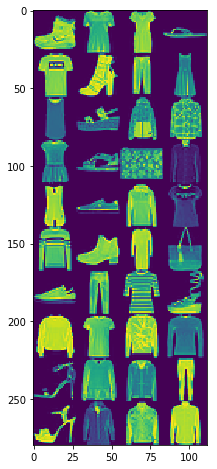

In [8]:
fig= plt.figure(figsize=(20,8))
plt.imshow(visual_array)
plt.show()

Cool colors, matplotlib

### Baseline Network

As a baseline network, let's build a fully connected classifier with 2 hidden layers.  As a more advanced network, we can use a convolutional neural network with several layers. As a comparison, we will use the fully connected classifier with many less neurons in the hidden layer.

In [9]:
def fully_connected_model(input_tensor, hidden_layers=[784,784]):
    # input_tensor here is expected to be a tensorflow object of shape (BATCH, 28, 28)
    
    #First, flatten the input into [BATCH, 28*28]:
    x = tf.layers.flatten(input_tensor)
    
       
    for layer in hidden_layers:
        x = tf.layers.dense(x, layer)
        x = tf.nn.relu(x)
        
    # Finally, connect the output to the right shape (10 outputs):
    x = tf.layers.dense(x, 10)
    
    return x

In [10]:
def convolutional_neural_network(input_tensor):
    # I am hard coding all the parameters here, since this is just about profiling.
    
    # Add an empty dimension to the input tensor to allow convolutions easily:
    
    x = tf.expand_dims(input_tensor, axis=-1)
    
    x = tf.layers.conv2d(inputs=x,
                         filters=8,
                         kernel_size=[3,3],
                         strides=[1,1],
                         padding='valid')
    x = tf.nn.relu(x)
   
    
    x = tf.layers.conv2d(inputs=x,
                         filters=8,
                         kernel_size=[3,3],
                         strides=[1,1],
                         padding='valid')
    x = tf.nn.relu(x)    
   
    
    # Downsample the network:
    
    x = tf.layers.max_pooling2d(inputs = x,
                                pool_size = 2,
                                strides = 2,
                                padding='valid')
    
   
    
    # To map to the final output, use 1x1 bottleneck and global average pooling:
    
    x = tf.layers.conv2d(inputs = x,
                         filters = 10,
                         kernel_size = (1,1),
                         padding='valid')
    
   
    
    pool_size  = x.get_shape().as_list()[1]
    batch_size = x.get_shape().as_list()[0]
    
    
    x = tf.layers.average_pooling2d(inputs = x,
                                    pool_size = pool_size,
                                    strides = 1,
                                    padding='valid')
    
    
    x = tf.squeeze(x)

   
    
    return x
    

### Building a full model

Set up a full model with input, optimizer, etc.  This is a good bit of code to put in one cell, but it's meant to be run multiple times with different parameters.

In [11]:

def trainer(BATCH_SIZE, LEARNING_RATE, LOGDIR, OPT, MODEL, EPOCHS, NAME, FORCE_CPU=False):

    if not os.path.isdir('log/'):
        os.mkdir('log/')

    if not os.path.isdir(LOGDIR):
        os.mkdir(LOGDIR)

    if not os.path.isdir(LOGDIR + '/traces/'):
        os.mkdir(LOGDIR + '/traces/')
        
    with open(LOGDIR + "training.log", 'w') as _out:


        tf.reset_default_graph()

        #Configure input:
        input_tensor = tf.placeholder(tf.float32, (None, 28, 28), name="input_image")
        input_labels = tf.placeholder(tf.int64, [None], name="input_label")

        # Build the model:
        logits = MODEL(input_tensor)

        # Calculate the loss function:
        loss = tf.losses.sparse_softmax_cross_entropy(labels=input_labels, logits=logits)
        tf.summary.scalar("TotalLoss",loss)

        prediction = tf.argmax(logits, axis=-1)

        accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, input_labels), tf.float32))
        tf.summary.scalar("Accuracy", accuracy)

        # Global Step variable
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        # Optimizer:
        optimizer = OPT(LEARNING_RATE)

        train_step = optimizer.minimize(loss, global_step = global_step)

        summary = tf.summary.merge_all()

        # How many trainable parameters are in this model?  Turns out, it's not so hard to check:
        total_parameters = 0
        for variable in tf.trainable_variables():
            this_variable_parameters = numpy.product([s for s in variable.shape])
            total_parameters += this_variable_parameters
            _out.write("{} has shape {} and {} total paramters to train.\n".format(
                variable.name,
                variable.shape,
                this_variable_parameters
            ))

        _out.write( "Total trainable parameters for this network: {} \n".format(total_parameters))


        # Here we can set up an optimizer for training the different models, and we will use profiling as well.  
        # Some of this is coming from this stack overflow answer: 
        # https://stackoverflow.com/questions/34293714/can-i-measure-the-execution-time-of-individual-operations-with-tensorflow/37774470#37774470



        # This configuration will allow us see the GPU usage with nvidia-smi.  That is, it won't hog the whole GPU.
        # Allow to turn off the GPU as well, for profiling demonstrations:
        if FORCE_CPU:
            config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, device_count = {'GPU': 0})
        else:
            config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
            config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        writer  = tf.summary.FileWriter(LOGDIR + '/train/')
        saver   = tf.train.Saver()

        session.run(tf.global_variables_initializer())
        writer.add_graph(session.graph)

        # Allow the full trace to be stored at run time.
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)

        # Training loop.  Compute how many steps per epoch (based on batch size), 
        # then perform that number of steps.
        steps_per_epoch = len(y_train) / BATCH_SIZE


        _out.write( "Beginning training, {} steps per epoch".format(steps_per_epoch))

        average_epoch_time = 0.0

        # Let's get the training start time:
        training_start_time = time.time()
        for e in range(EPOCHS):
            epoch_start_time = time.time()
            data_access_index = 0

            # We'll also get an average of time per training step:
            training_step_cummulative_time = 0.0
            n_training_steps = 0

            profiling_step_cummulative_time = 0.0
            n_profiling_steps = 0

            for step in range(steps_per_epoch):

                # Run the global step operation:
                current_global_step = session.run(global_step)

                # Construct a feed dict
                fd = {
                    input_tensor : x_train[data_access_index:data_access_index+BATCH_SIZE],
                    input_labels : y_train[data_access_index:data_access_index+BATCH_SIZE]
                }

                # Increment the the data_access_index:
                data_access_index += BATCH_SIZE

                # On the very first step, let's make a summary:
                if step == 0:
                    _out.write( "Generating a summary at global step {}".format(current_global_step))

                    # Create a fresh metadata object:
                    run_metadata = tf.RunMetadata()

                    # Run the training step plus the summary:
                    start = time.time()
                    _, summ = session.run([train_step, summary], feed_dict=fd, options=run_options, run_metadata=run_metadata)
                    profiling_step_cummulative_time += time.time() - start
                    n_profiling_steps += 1

                    # Add the summary to tensorboard:
                    # (Here, we'll add things as a function of current epoch number)
                    epoch_number = e + 1.0*step / steps_per_epoch  
                    writer.add_summary(summ, epoch_number)
                    # And, add the run metadata:
                    writer.add_run_metadata(run_metadata, NAME + "step_{}".format(current_global_step),current_global_step)

                    # This saves the timeline to a chrome trace format:
                    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
                    chrome_trace = fetched_timeline.generate_chrome_trace_format()
                    with open(LOGDIR + '/traces/timeline_{}.json'.format(current_global_step), 'w') as f:
                        f.write(chrome_trace)
                else:
                    start = time.time()
                    session.run(train_step, feed_dict=fd, options=run_options, run_metadata=run_metadata)
                    training_step_cummulative_time += time.time() - start
                    n_training_steps += 1

            epoch_end_time = time.time()
            average_epoch_time += epoch_end_time - epoch_start_time
            # Compute the loss of the most recent batch:
            current_loss = session.run(loss, feed_dict=fd)
            _out.write( "Compeleted epoch {} of {}, current loss is {:.4f}".format(e,EPOCHS, current_loss))
            _out.write( "  Epoch training time was {:.4f}".format(epoch_end_time - epoch_start_time))
            _out.write( "  Average time per train step: {:.4f}".format(training_step_cummulative_time / n_training_steps))
            _out.write( "  Average time per prof. step: {:.4f}".format(profiling_step_cummulative_time / n_profiling_steps))
            _out.write( "-------------------------------------")



        training_end_time = time.time()
        # Save the trained model so we can reload and profile the inference later:
        saver.save(session,LOGDIR + "/train/checkpoints/save", global_step=current_global_step)

        # While the graph is open and loaded, let's run inference on the test set to evaluate performance
        run_metadata = tf.RunMetadata()

        acc, loss = session.run([accuracy, loss], 
                                feed_dict = {
                                    input_tensor : x_test,
                                    input_labels : y_test
                                },
                                options=run_options, 
                                run_metadata=run_metadata
                               )
        writer.add_run_metadata(run_metadata, NAME + "inference",current_global_step)
        fetched_timeline = timeline.Timeline(run_metadata.step_stats)
        chrome_trace = fetched_timeline.generate_chrome_trace_format()
        with open(LOGDIR + '/traces/timeline_inference.json', 'w') as f:
            f.write(chrome_trace)

        session.close()

        # Return some metrics:
        return {
            'total_time' : training_end_time - training_start_time,
            'epoch_time' : average_epoch_time / EPOCHS,
            'step_time'  : training_step_cummulative_time / n_training_steps,
            'loss'       : loss,
            'accuracy'   : acc, 
            'parameters' : total_parameters,
        }

Let me extract some of the important parts of that block of code above:

```python
if FORCE_CPU:
    config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True, device_count = {'GPU': 0})
else:
    config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
    config.gpu_options.allow_growth = True
session = tf.Session(config=config)
writer  = tf.summary.FileWriter(LOGDIR + '/train/')
```

There are two options here.  If the model is forced to run and train on the CPU, the device_count parameter of the ConfigProto forces the number of GPUs equal to zero.  Otherwise, the model will run on the GPU if possible

Other important pieces: allow_soft_placement will let tensorflow pick the best place for an operation, and log_device_placement (if changed to true) will print out the location of every operation.  Setting `config.gpu_options.allow_growth = True` let's the used memory of the GPU only grow as needed, instead of claiming the whole GPU.

```python
# Allow the full trace to be stored at run time.
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)

```

This code sets the run options to allow a full trace of every operation during a `session.run` call.  It only works when you pass it to the `run` call, which we do only at summary steps:

```python

# (This code is truncated from above)

# Create a fresh metadata object:
run_metadata = tf.RunMetadata()

# Run the training step plus the summary:
_, summ = session.run([train_step, summary], feed_dict=fd, options=run_options, run_metadata=run_metadata)                

# And, add the run metadata:
writer.add_run_metadata(run_metadata, NAME + "step_{}".format(current_global_step),current_global_step)


```

Note the frest instance of run_metadata, which gets passed to the `session.run` call along with the run_options from above.  The meta data gets added to the log with a seperate call to the writer than the summary: `writer.add_run_metadata`, which requires a name and a step.

You can also save the timeline into a chrome trace format.  It's not more information, but it allows a different visualization in terms of the entire timeline:

```python
# This saves the timeline to a chrome trace format:
fetched_timeline = timeline.Timeline(run_metadata.step_stats)
chrome_trace = fetched_timeline.generate_chrome_trace_format()
with open(LOGDIR + '/traces/timeline_{}.json'.format(current_global_step), 'w') as f:
    f.write(chrome_trace)
```

Another thing to note is that we can save the metadata and timeline for the inference pass too.  This runs on more events (the full testing set), but you can see the relative speed of the operations without the back prop step as well:

```python

# While the graph is open and loaded, let's run inference on the test set to evaluate performance
run_metadata = tf.RunMetadata()

acc, loss = session.run([accuracy, loss], 
                        feed_dict = {
                            input_tensor : x_test,
                            input_labels : y_test
                        },
                        options=run_options, 
                        run_metadata=run_metadata
                       )
writer.add_run_metadata(run_metadata, NAME + "inference",current_global_step)

```

## Running the training and comparing results

Here comes the play-at-home part of this tutorial.  By adjusting the different parameters, we can change the performance, run speed, and memory usage of the network (obviously).  Let's experiment with a few iterations, then take a look at tensorboard to see what's going on:

In [12]:
global_results = dict()
# We also fix the BATCH_SIZE and number of EPOCHS for a fair comparison:
BATCH_SIZE = 100
EPOCHS = 10
LEARNING_RATE = 0.001

In [13]:
def light_connected_model(input_tensor):
    return fully_connected_model(input_tensor, hidden_layers=[128,128])

In [14]:
for network in ['fully_connected', 'light_connected', 'convolutional']:
    for opt in ['ADAM', 'SGD']:
        for device in ['CPU', 'GPU']:
            start = time.time()
            NAME = network + "_" + opt + "_" + device
            if opt == 'ADAM':
                OPT = tf.train.AdamOptimizer
            else:
                OPT = tf.train.GradientDescentOptimizer
            
            LOGDIR = 'log/' + NAME
            if network == 'fully_connected':
                MODEL = fully_connected_model
            elif network == 'light_connected':
                MODEL = light_connected_model
            else:
                MODEL = convolutional_neural_network
                
            if device == 'CPU':
                results = trainer(BATCH_SIZE, LEARNING_RATE, LOGDIR, OPT, MODEL, EPOCHS, NAME, FORCE_CPU=True)
            else:
                results = trainer(BATCH_SIZE, LEARNING_RATE, LOGDIR, OPT, MODEL, EPOCHS, NAME)
            
            
            results['name'] = NAME
            results['batch_size'] = BATCH_SIZE
            results['learning_rate'] = LEARNING_RATE
            results['opt'] = opt
            results['model'] = network
            results['epochs'] = EPOCHS
            global_results[NAME] = results
            print "Finished training {} in {:.2f}s".format(NAME, time.time() - start)

Finished training fully_connected_ADAM_CPU in 59.27s
Finished training fully_connected_ADAM_GPU in 22.35s
Finished training fully_connected_SGD_CPU in 52.55s
Finished training fully_connected_SGD_GPU in 17.82s
Finished training light_connected_ADAM_CPU in 14.67s
Finished training light_connected_ADAM_GPU in 17.83s
Finished training light_connected_SGD_CPU in 12.87s
Finished training light_connected_SGD_GPU in 15.24s
Finished training convolutional_ADAM_CPU in 191.38s
Finished training convolutional_ADAM_GPU in 50.99s
Finished training convolutional_SGD_CPU in 191.46s
Finished training convolutional_SGD_GPU in 45.04s


Probably this takes a little time to run.  For me, as you can see, it took awhile.

## Comparing results

There are three parts to this comparison that I'll go through.  One is based on comparing the metrics from above, which are based on timestamps in execution.  The second is to look at tensorboard, which I'll show below.  The last is comparisons based on chrome tracing, which requires the chrome browser, but can still provide interesting views.

#### Timestamp comparisons

There are several comparisons to make here: Adam vs. SGD, Dense (large) vs. Dense (light) vs. CNN, and CPU vs. GPU.  That's a total of 12 categories, so we can fit it all on the same plot, but let's break it down into some categories:

- GPU trained networks in blue
- CPU trained networks in green
- Adam trained networks are solid colors
- SGD trained networks are hatched

In [21]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

This little chunk of code just adds color scale, hatching, and index for a bar chart to the results:

In [22]:
for key in global_results.keys():
    print key

convolutional_ADAM_GPU
fully_connected_ADAM_GPU
light_connected_SGD_GPU
convolutional_ADAM_CPU
fully_connected_ADAM_CPU
light_connected_ADAM_GPU
light_connected_SGD_CPU
convolutional_SGD_GPU
fully_connected_SGD_CPU
convolutional_SGD_CPU
fully_connected_SGD_GPU
light_connected_ADAM_CPU


In [23]:
index = 0
for network in ['fully_connected', 'convolutional', 'light_connected']:
    index += 1
    for optimizer in ['_ADAM', '_SGD']:
        for device in ['_GPU', '_CPU']:
            if optimizer == '_ADAM':
                hatch=""
            else:
                hatch="/"
            
            if device == '_CPU':
                color = 'green'
            else:
                color = 'slateblue'
                            
            name = network + optimizer + device
            global_results[name]['index'] = index
            global_results[name]['color'] = color
            global_results[name]['hatch'] = hatch
            
            index += 1

legend_elements = [
    Patch(facecolor='white',     edgecolor='b', label='Adam'),
    Patch(facecolor='white',     edgecolor='b', label='SGD',hatch="/"),
    Patch(facecolor='slateblue', edgecolor='b', label='GPU'),
    Patch(facecolor='green',     edgecolor='b', label='CPU'),
]

Plot time per epoch for each instance:

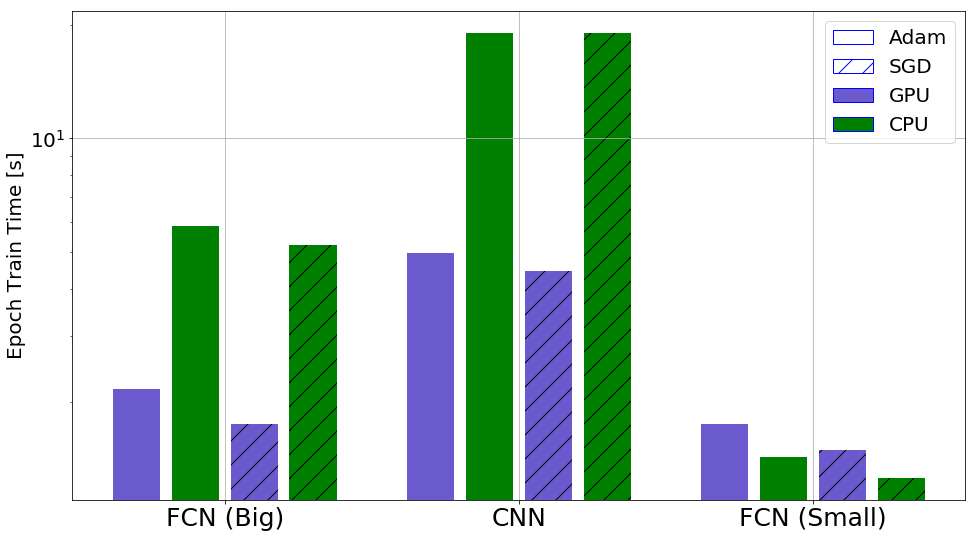

In [24]:
figure = plt.figure(figsize=(16,9))

inds = []
colors = []
hatch = []
values = []

for result in global_results:
    ind = global_results[result]['index']
    color = global_results[result]['color']
    hatch = global_results[result]['hatch']
    value = global_results[result]['epoch_time']

    
    plt.bar(ind, value, color=color, hatch=hatch )

    
ax = plt.gca()

locs = [2.5, 7.5, 12.5]
names = ["FCN (Big)", "CNN", "FCN (Small)"]

plt.xticks(locs, names)

ax.set_yscale('log')

plt.ylabel("Epoch Train Time [s]", fontsize=20)

# Make the labels readable:
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 


ax.legend(handles=legend_elements, fontsize=20)
    
plt.grid(True)
plt.show()

So, here's an interesting result already: The smallest network trains fastest of all the networks, (which is not surprising), but the CPU implementation is beating the GPU implementation for performance!  We'll look into why that's happening next.

Another interesting note is that SGD is training faster (per epoch) than Adam - which is expected, since Adam has a few extra computations per update.  On the other hand, the accuracy on the test set is better after 2 epochs with Adam than SGD:

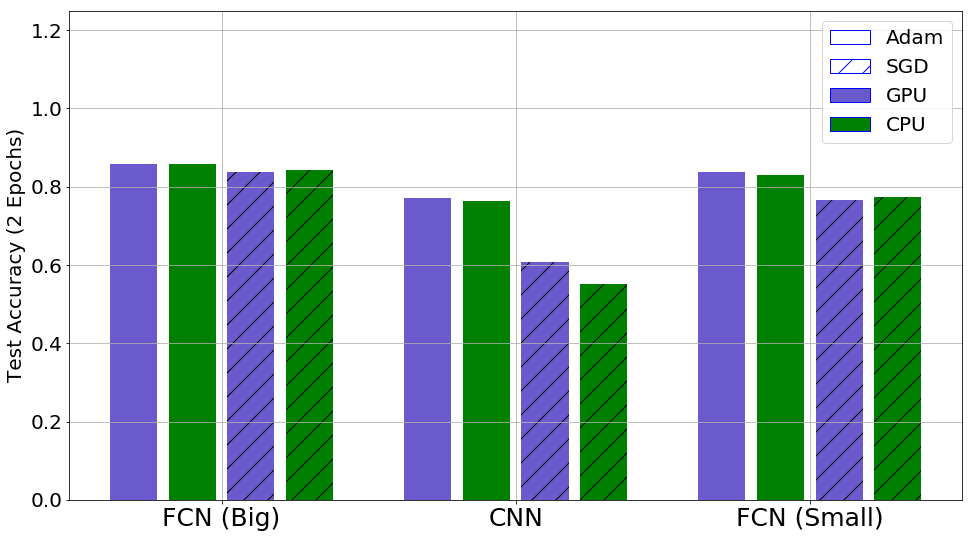

In [26]:
figure = plt.figure(figsize=(16,9))

inds = []
colors = []
hatch = []
values = []

for result in global_results:
    ind = global_results[result]['index']
    color = global_results[result]['color']
    hatch = global_results[result]['hatch']
    value = global_results[result]['accuracy']

    
    plt.bar(ind, value, color=color, hatch=hatch )

    
ax = plt.gca()

locs = [2.5, 7.5, 12.5]
names = ["FCN (Big)", "CNN", "FCN (Small)"]

plt.xticks(locs, names)

# ax.set_yscale('log')
ax.set_ylim([0,1.25])

plt.ylabel("Test Accuracy (2 Epochs)", fontsize=20)

# Make the labels readable:
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 


ax.legend(handles=legend_elements, fontsize=20)
    
plt.grid(True)
plt.show()

In all cases, after 10 epochs Adam is outperforming SGD on the testing set.  There is some indication that this is not true for very extended training (Adam and other adaptive training methods have a larger gap between train and test than SGD, according to some experiments), but on the other hand these results are not really good yet anyways.  90% accuracy on this training set is not particularly excellent, but that's not the point of the tutorial anyways.

### Comparison of operation memory and timelines.

To see how much time and memory a particular operation was using, you can open up the graph in tensorboard and look at the nodes.  Select the model you want, and then under session runs you can see a list of stored run information for every time it was stored.  If you ran the code above, you should have 12 models, and each model ought to have 10 different session runs (include "None").  The session runs then allow you to access the radio buttons on the left side to color code the nodes by device, memory usage, compute time, and a few more options.  When I look at the CNN trained with Adam on my GPU, I see this:

![Basic Tensorboard Layout](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_GPU/Basic.png)

When I click on the conv2d_1 node, after sorting my memory usage, I see this:

![conv2d_1](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_GPU/Memory_conv2d_1.png)

Note that this is indicated that the conv2d_1 node too 4.01 MB of memory and 788us to run (see the numbers in the inset box on the top right of the screen).  The gradients node is really lighting up though, we can see how much memory it required:

![Gradients](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_GPU/Memory_gradients.png)

So, the gradients operation took 40.5MB and 3.31ms to run.  How does this compare to the CPU bound network?  If I open that one similarly in tensorboard, we see:

![GPU conv2d_1](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_CPU/Memory_conv2d_1.png)
![GPU conv2d_1](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_CPU/Memory_gradients.png)

As we see, the CPU implementation took much longer for the two operations shown here.

### Lightweight network comparison

One thing that is notable above is that the lightweight network took less time on the CPU than it did on the GPU.  What's going on here?  Let's look at the traces in chrome to figure out what's happening.  To do this, open the .json files that are saved in chrome by going to the `chrome://tracing` address.  You can click on the `Load` button to open up a trace.  Let's take a look at the convolutional network on the GPU real quick:

![trace](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_GPU/trace_screenshot_conv2d_1.png)

And you can compare this to the CPU version of the same network:

![trace](imgs/2018-09-25-Profiling-Tensorflow/convolutional_ADAM_CPU/trace_screenshot_conv2d_1.png)

From these comparisons, you can see that the conv2d operations are running much faster on the GPU than the CPU (note the difference in scales) and further, all the time consuming operations on the GPU are much faster.

Finally, let's compare the lightwight fully connected network.  It's performance in terms of loss and accuracy is suboptimal, but it had the quirk of training faster on the CPU than the GPU.  You can see in the chrome trace where it's spending it's time:

### CPU Version:
![light_training_cpu](imgs/2018-09-25-Profiling-Tensorflow/light_fully_connected_ADAM_CPU/train_600_trace.png)

### GPU Version:
![light_training_gpu](imgs/2018-09-25-Profiling-Tensorflow/light_fully_connected_ADAM_GPU/train_600_trace.png)

Those small operations towards the beginning are copying data to the GPU, after which there is a bit of a pause.  Then, the GPU *does* compute operations much faster, but the CPU has enough of a headstart that it completes the training slightly ahead of the GPU.  With a bigger network, the GPU should start to win this race more easily.

As a final comparison, we can look at the trace of the inference on the test set for this network design.  The test set is big (10k events) and it all got processed in one shot, so we expect longer memory copies but also more computation:

### GPU:
![GPU_test_inference](imgs/2018-09-25-Profiling-Tensorflow/light_fully_connected_ADAM_GPU/trace_inference.png)

### CPU:
![CPU_test_inference](imgs/2018-09-25-Profiling-Tensorflow/light_fully_connected_ADAM_CPU/trace_inference.png)

Note that the time scale for the GPU is about 7.5 ms, while for the CPU it's more like 17ms.  The GPU spends *most* of it's time doing a memory copy, but then the inference pass is extremely quick compared to the CPU, and the final inference result is delivered in half the time.

## Conclusions

In this blog post, we looked at how to compare run times and memory usage of different network architectures.  There were three main techniques used.  First, we used simple python time.time() calls to measure time stamps before and after key events (training iterations, epoch calculations, etc).  This gave a good indication of the total time spent training.

Second, we look looked at tensorboard output which showed us both time per operation as well as memory usage per operation.  This is a good way to spot bottle necks and memory hogging operations.

Last, we compared the traces in `chrome://tracing` to see the sequential order of operations, how they were distributed across CPU and GPU cores, and what operations took the longest.  This let us see why the CPU version of the lighter fully conencted neural network was training faster than the GPU version.

If you run this notebook yourself, it will generate all of the tools you need to look at these results yourself.  You will get tensorboard output and chrome traces saved.  I encourage you to try it, and as well to modify the networks and see how the memory and compute time performance changes.